# Pattern Generation with Attention GAN


Using an Attention GAN network diagram to generate patterns improves model performance on learning more complex patterns, such as floral and geometric. This architecture also has the benefit of using the entire dataset to learn the different patterns and uses the pattern label as a feature itself. 

Cited Sources: 

* [SELF ATTENTION GAN TUTORIAL](https://colab.research.google.com/drive/1BHRrau_awrfisc7z-q228hCRvt_TE3u-) by [Avik Pal](https://avik-pal.github.io)
* [Self-Attention Generative Adversarial Networks by Zhang et. al.](https://arxiv.org/abs/1805.08318). 
* [Understanding AttnGAN: Text-to-Image convertor](https://codeburst.io/understanding-attngan-text-to-image-convertor-a79f415a4e89) by Sachin Joglekar

This tutorial assumes that your system has **Pytorch** and **torchgan** installed properly. If not, head over to the installation instructions on the [official documentation website](https://torchgan.readthedocs.io/en/latest/).

In [1]:
# General Imports
import os
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import HTML
# Pytorch and Torchvision Imports
import torch
import torchvision
from torch.optim import Adam
import torch.nn as nn
import torch.utils.data as data
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.utils as vutils
# Torchgan Imports
import torchgan
from torchgan.layers import SelfAttention2d
from torchgan.models import Generator, Discriminator
from torchgan.losses import WassersteinGeneratorLoss, WassersteinDiscriminatorLoss, WassersteinGradientPenalty
from torchgan.trainer import Trainer

import PIL


In [2]:
torch.cuda.is_available()

False

In [3]:
# Set random seed for reproducibility
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
print("Random Seed: ", manualSeed)

Random Seed:  999


# Applying Pattern Dataset 

https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [6]:
import torch
from torchvision import transforms, datasets

In [7]:
#pattern dataset Data Loader
#apply tranformations

pattern_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5,), std = (0.5,))])


pattern_dataset = datasets.ImageFolder(root='./data/custom'
                                       , transform = pattern_transform)

dataloader = torch.utils.data.DataLoader(pattern_dataset, batch_size=64, shuffle=True)

## GENERATOR MODEL

# New Section

The SAGANGenerator receives an input noise vector of size $batch\ size \times encoding\ dims$. The output must be a torch Tensor of size $batch\ size \times 1 \times 32 \times 32$ conforming to the input MNIST size. We transform the noise to the image in the following way:


1. **Channel Dimension**: $encoding\ dims \rightarrow d \rightarrow \frac{d}{2} \rightarrow \frac{d}{4} \rightarrow 1$.
2. **Image size**: $(1 \times 1) \rightarrow (4 \times 4) \rightarrow (8 \times 8) \rightarrow (16 \times 16) \rightarrow (32 \times 32)$.

We are going to use **LeakyReLU** as the activation. Using ReLU will kill most of the gradients and hence convergence is critically slowed down. Hence it is a valid choice for the activation. At the end of the model we use a **Tanh** activation. This ensures that the pixel values range from $(-1\ to\ 1)$.

---

**SelfAttention2d** is present out-of-box in torchgan. Self Attention simply learns an attention map to learn ot attend to certain places of the image. It contains 3 convolutional layers, named **query**, **key** and **value**. The weights of these layers are learned. We compute the attention map by:

$$attention = softmax((query(x)^T \times key(x)))$$
$$output = \gamma \times value(x) \times attention + x $$

$\gamma$ is simply a scaling parameter which is also learning. Its value is initially set to 0. As result in the beginning, the Self Attention Layer does nothing. As the network starts learning the features the value of $\gamma$ increases and so does the effect of the attention map. This is done to ensure that the model initially focusses on learning the local features (which are relatively easy to learn). Once it has learnt to detect the local features it focusses on learning the more
global features.

For more information on SelfAttention2d, use `help(SelfAttention2d)`.

---

The Generator model needs 2 inputs, the $1^{st}$ one is the **encoding_dims** and the $2^{nd}$ one is the **label_type**. Since SAGAN is not a conditional model, we are going to set the **label_type** as **'none'**. For conditioned models there are 2 options - **'generated'** and **'required'**. We shall discuss them in detail in later tutorials.

The training of SAGAN is same as the standard GANs, it is only an architectural improvement. Hence subclassing the Generator, allows us to use the default **train_ops**. We shall be discussing on how to write a custom **train_ops** in a future tutorial.

In [8]:
class SAGANGenerator(Generator):
    def __init__(self, encoding_dims=100, step_channels=64):
        super(SAGANGenerator, self).__init__(encoding_dims *3, 'none')
        d = int(step_channels * 4) 
        self.model = nn.Sequential(
            nn.ConvTranspose2d(self.encoding_dims, d, 4, 1, 0, bias=False),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(d, d // 2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            SelfAttention2d(d // 2),
            nn.ConvTranspose2d(d // 2, d // 4, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            SelfAttention2d(d // 4),
            nn.ConvTranspose2d(d // 4, 3, 4, 2, 1, bias=False), nn.Tanh())

    def forward(self, x):
        x = x.view(-1, x.size(1), 1, 1)
        return self.model(x)

# New Section

In [19]:
noise = np.random.normal(size=(64,300))
noise.shape
noise = torch.from_numpy(noise)
noise = noise.view(-1,noise.size(1),1,1)
noise.size()


torch.Size([64, 300, 1, 1])

## DISCRIMINATOR MODEL

The SAGANDiscriminator receives an image in the form of a torch Tensor of size $batch\ size \times 1 \times 32 \times 32$. It must output a tensor of size $batch\ size$, where each value corresponds to the confidence of whether or not that is image is real. Since we use a **Tanh** activation at the end of the model, the outputs **cannot be interpreted as probabilities**. Instead we interpret them as follows:

1. A **Higher** value (*closer to 1.0*) indicates that the discriminator believes the image to be a real one.
2. A **Lower** value (*closer to -1.0*) indicates that the discriminator believes the image to be a fake one.

---

For reasons same as above we use a **LeakyReLU** activation. The conversion of the image tensor to the confidence scores are as follows:

1. **Channel Dimension**: $1 \rightarrow d \rightarrow 2 \times d \rightarrow 4 \times d \rightarrow 1$.
2. **Image size**: $(32 \times 32) \rightarrow (16 \times 16) \rightarrow (8 \times 8) \rightarrow (4 \times 4) \rightarrow (1 \times 1)$.

---

The Discriminator also needs 2 inputs. The $1^{st}$ one is the channel dimension of the input image. In our case, we have grayscale images so this value is *1*. The $2^{nd}$ argument is the **label_type**, which is again **'none'**


In [20]:
class SAGANDiscriminator(Discriminator):
    def __init__(self, step_channels=64):
        super(SAGANDiscriminator, self).__init__(3, 'none')
        d = step_channels
        self.model = nn.Sequential(
            nn.Conv2d(self.input_dims, d, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
              nn.Conv2d(d, d * 2, 4, 2, 1, bias=False),
              nn.LeakyReLU(0.2),
            SelfAttention2d(d * 2),
            nn.Conv2d(d * 2, d * 4, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            SelfAttention2d(d * 4),
            nn.Conv2d(d * 4, 3, 4, 1, 0, bias=False), nn.Tanh())

    def forward(self, x):
        return self.model(x)

## MODEL PARAMETERS & HYPERPARAMETERS

In this section we are going to define how the model is going to look like, what their optimizers are going to be and every other possible hyperparameter. We use a dictionary to feed the input into the trainer. We believe it to be a much cleaner approach than individual arguments which tend to limit the capacity of the Trainer.

---

We follow a standard naming system for parsing arguments. **name** refers to the **class** whose object is to be created. **args** contains the arguments that will be fed into the **class** while instantiating it. The keys refer to the **variable names** with which the **object** shall be stored in the **Trainer**. This storage pattern allows us to have customs **train_ops** for Losses with no furthur headaches, but thats again for a future discussion. The items in the dictionary are allowed to have the following keys:

1. "name": The class name for the model.
2. "args": Arguments fed into the class.
3. "optimizer": A dictionary containing the following key-value pairs
    * "name"
    * "args"
    * "var": Variable name for the optimizer. This is an optional argument. If this is not provided, we assign the optimizer the name **optimizer_{}** where {} refers to the variable name of the model.
    * "scheduler": Optional scheduler associated with the optimizer. Again this is a dictionary with the following keys
        * "name"
        * "args"

---

Lets see the interpretation of the `network_params` defined in the following code block. This dictionary gets interpreted as follows in the Trainer:

```python
generator = SAGANGenerator(step_channels = 32)
optimizer_generator = Adam(generator.parameters(), lr = 0.0001, betas = (0.0, 0.999))

discriminator = SAGANDiscriminator(step_channels = 32)
optimizer_discriminator = Adam(discriminator.parameters(), lr = 0.0004, betas = (0.0, 0.999))
```

As observed we are using the **TTUR (Two Timescale Update  Rule)** for training the models. Hence we can easily customize most of the training pipeline even with such high levels of abstraction.

In [21]:
network_params = {
    "generator": {"name": SAGANGenerator, "args": {"step_channels": 32},
                  "optimizer": {"name": Adam, "args": {"lr": 0.0001, "betas": (0.0, 0.999)}}},
    "discriminator": {"name": SAGANDiscriminator, "args": {"step_channels": 32},
                      "optimizer": {"name": Adam, "args": {"lr": 0.0004, "betas": (0.0, 0.999)}}}
}

In [22]:
network_params

{'generator': {'name': __main__.SAGANGenerator,
  'args': {'step_channels': 32},
  'optimizer': {'name': torch.optim.adam.Adam,
   'args': {'lr': 0.0001, 'betas': (0.0, 0.999)}}},
 'discriminator': {'name': __main__.SAGANDiscriminator,
  'args': {'step_channels': 32},
  'optimizer': {'name': torch.optim.adam.Adam,
   'args': {'lr': 0.0004, 'betas': (0.0, 0.999)}}}}

Training the models are quite expensive. Hence we will train the models for **40** epochs if a GPU is available, else we will be training for only **5** epochs. We recommend using the **GPU runtime** in Colab. The images will not look even close to realistic in **5** epochs but shall be enough to show that it is learning to generate good quality images. 

In [23]:
torch.cuda.is_available()

False

In [38]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    # Use deterministic cudnn algorithms
    torch.backends.cudnn.deterministic = True
    epochs = 10
else:
    device = torch.device("cpu")
    epochs = 50

print("Device: {}".format(device))
print("Epochs: {}".format(epochs))

Device: cpu
Epochs: 50


We need to feed a list of losses to the trainer. These losses control the optimization of the model weights. We are going to use the following losses, all of which are defined in the **torchgan.losses** module.

1. WassersteinGeneratorLoss
2. WassersteinDiscriminatorLoss
3. WassersteinGradientPenalty

Since we are not using Spectral Normalization as suggested in the paper, we shall be using Wasserstein Gradient Penalty to enforce the Lipschitz condition. (SpectralNorm2d is present in the package, we just choose to use Gradient Penalty instead for demonstration purposes).

In [39]:
losses_list = [WassersteinGeneratorLoss(), WassersteinDiscriminatorLoss(), WassersteinGradientPenalty()]

## VISUALIZING THE TRAINING DATA

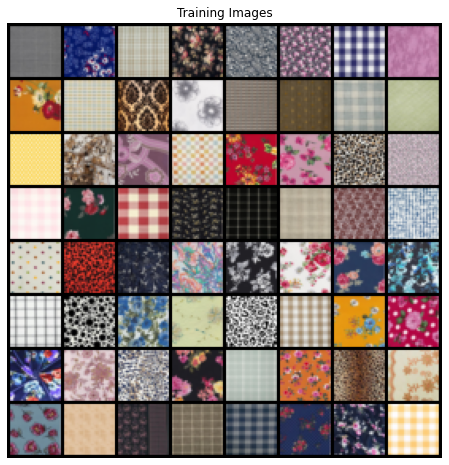

In [40]:
# Plot some of the training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

## TRAINING THE GENERATOR & DISCRIMINATOR

Next we simply feed the network descriptors and the losses we defined previously into the Trainer. Then we pass the **MNIST DataLoader** to the trainer object and wait for training to complete.

---

Important information for visualizing the performance of the GAN will be printed to the console. The best and recommended way to visualize the training is to use **tensorboardX**. It plots all the data and periodically displays the generated images. It allows us to track failure of the model early.

In [41]:
trainer = Trainer(network_params, losses_list, sample_size=64, epochs=epochs, device=device)

In [42]:
trainer(dataloader)

Saving Model at './model/gan0.model'
Epoch 1 Summary
Epoch time duration : 24.936455249786377
generator Mean Gradients : 0.3185083331746214
discriminator Mean Gradients : 58.780675026036086
Mean Running Discriminator Loss : -0.14492741620435315
Mean Running Generator Loss : -0.18101060278528497
Generating and Saving Images to ./images/epoch1_generator.png



C:\Users\aaliy\.conda\envs\Python37\lib\site-packages\torchvision\utils.py:64: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  "The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. "


Saving Model at './model/gan1.model'
Epoch 2 Summary
Epoch time duration : 25.77631711959839
generator Mean Gradients : 0.31610046432632527
discriminator Mean Gradients : 94.56089613733245
Mean Running Discriminator Loss : -0.1635967767876676
Mean Running Generator Loss : -0.0004926699035091919
Generating and Saving Images to ./images/epoch2_generator.png

Saving Model at './model/gan2.model'
Epoch 3 Summary
Epoch time duration : 24.699634313583374
generator Mean Gradients : 0.24922634301371366
discriminator Mean Gradients : 78.52883235860897
Mean Running Discriminator Loss : -0.19033414683789124
Mean Running Generator Loss : -0.0156951395718021
Generating and Saving Images to ./images/epoch3_generator.png

Saving Model at './model/gan3.model'
Epoch 4 Summary
Epoch time duration : 24.485273838043213
generator Mean Gradients : 0.22071643829489576
discriminator Mean Gradients : 74.18763904511276
Mean Running Discriminator Loss : -0.20500773827323154
Mean Running Generator Loss : -0.00835

Saving Model at './model/gan4.model'
Epoch 25 Summary
Epoch time duration : 24.765995502471924
generator Mean Gradients : 0.3830019103386414
discriminator Mean Gradients : 171.12904442987764
Mean Running Discriminator Loss : -0.21989654699304262
Mean Running Generator Loss : 0.023807036318403498
Generating and Saving Images to ./images/epoch25_generator.png

Saving Model at './model/gan0.model'
Epoch 26 Summary
Epoch time duration : 25.353498935699463
generator Mean Gradients : 0.4005006073737055
discriminator Mean Gradients : 168.42207252568127
Mean Running Discriminator Loss : -0.2127475862634437
Mean Running Generator Loss : 0.010239778335502948
Generating and Saving Images to ./images/epoch26_generator.png

Saving Model at './model/gan1.model'
Epoch 27 Summary
Epoch time duration : 25.04872155189514
generator Mean Gradients : 0.4127437217970279
discriminator Mean Gradients : 163.39836206277968
Mean Running Discriminator Loss : -0.20754071929582105
Mean Running Generator Loss : 0.02

Saving Model at './model/gan2.model'
Epoch 48 Summary
Epoch time duration : 24.676618337631226
generator Mean Gradients : 0.39051467687907104
discriminator Mean Gradients : 107.29387742752158
Mean Running Discriminator Loss : -0.15846768699736657
Mean Running Generator Loss : 0.03049943634533437
Generating and Saving Images to ./images/epoch48_generator.png

Saving Model at './model/gan3.model'
Epoch 49 Summary
Epoch time duration : 24.93337345123291
generator Mean Gradients : 0.38633991859451383
discriminator Mean Gradients : 105.99794537566216
Mean Running Discriminator Loss : -0.15690336378071015
Mean Running Generator Loss : 0.030010790967496745
Generating and Saving Images to ./images/epoch49_generator.png

Saving Model at './model/gan4.model'
Epoch 50 Summary
Epoch time duration : 24.733418703079224
generator Mean Gradients : 0.38177031298443115
discriminator Mean Gradients : 104.27486013751599
Mean Running Discriminator Loss : -0.15578017192365862
Mean Running Generator Loss : 0

It is not mandatory to call this function but it is good practice to do so. It turns off all logging services.

In [43]:
trainer.complete()

Saving Model at './model/gan0.model'


In [44]:
noise = np.random.normal(size=(64,300))
noise.shape
noise = torch.from_numpy(noise)
noise.size()

torch.Size([64, 300])

In [45]:
noise=noise.cuda()
noise = noise.float()
output = trainer.generator(noise)
output = noise.cpu()
output = output.numpy()
output[0]

AssertionError: Torch not compiled with CUDA enabled

## VISUALIZING THE GENERATED DATA

All these visualizations are directly available on Tensorboard or Visdom but for the sake of this tutorial we will compare the images using matplotlib. If you are running this locally it is best to skip over this part and directly visualize these from the default logging services.

> Indented block



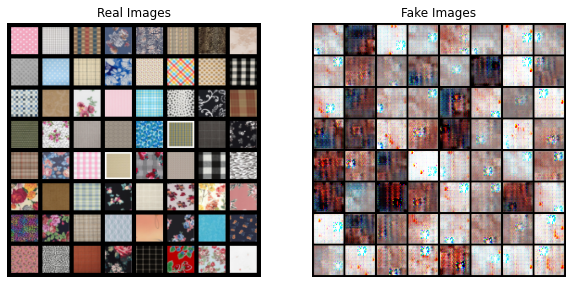

In [46]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(plt.imread("{}/epoch{}_generator.png".format(trainer.recon, trainer.epochs)))
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(plt.imread("{}/epoch{}_generator.png".format(trainer.recon, i)))] for i in range(1, trainer.epochs + 1)]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

# Play the animation
HTML(ani.to_jshtml())